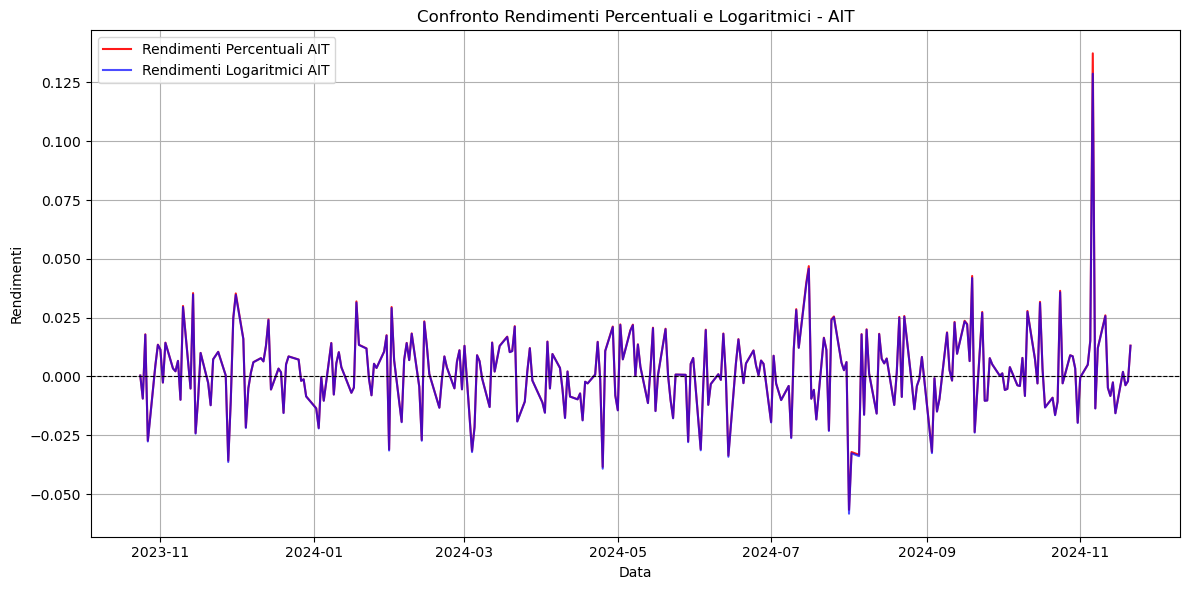

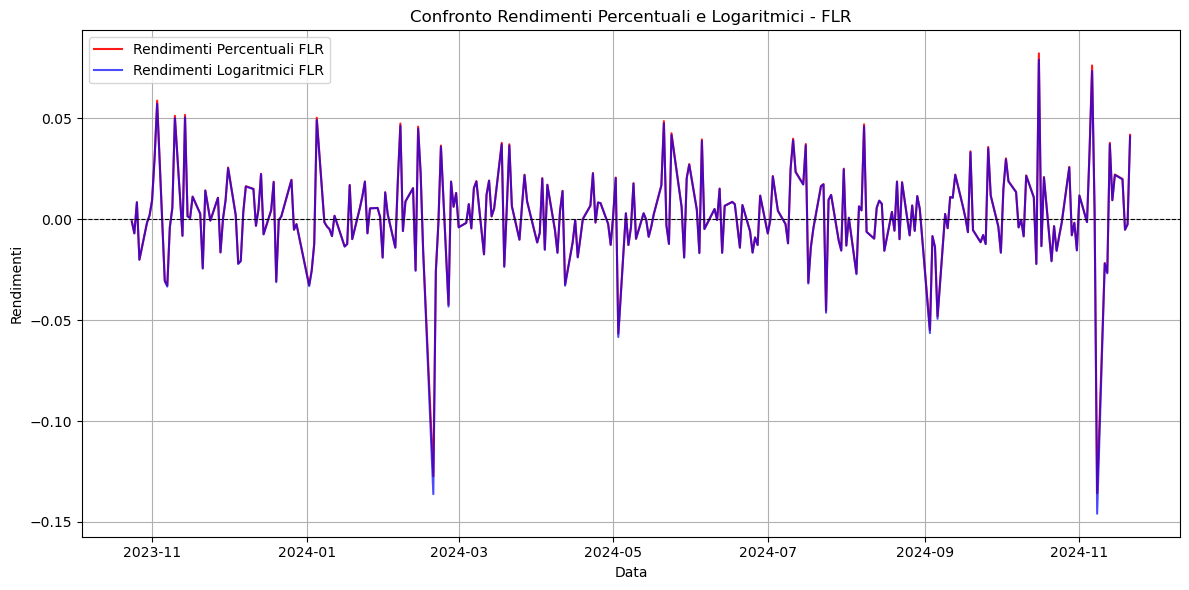

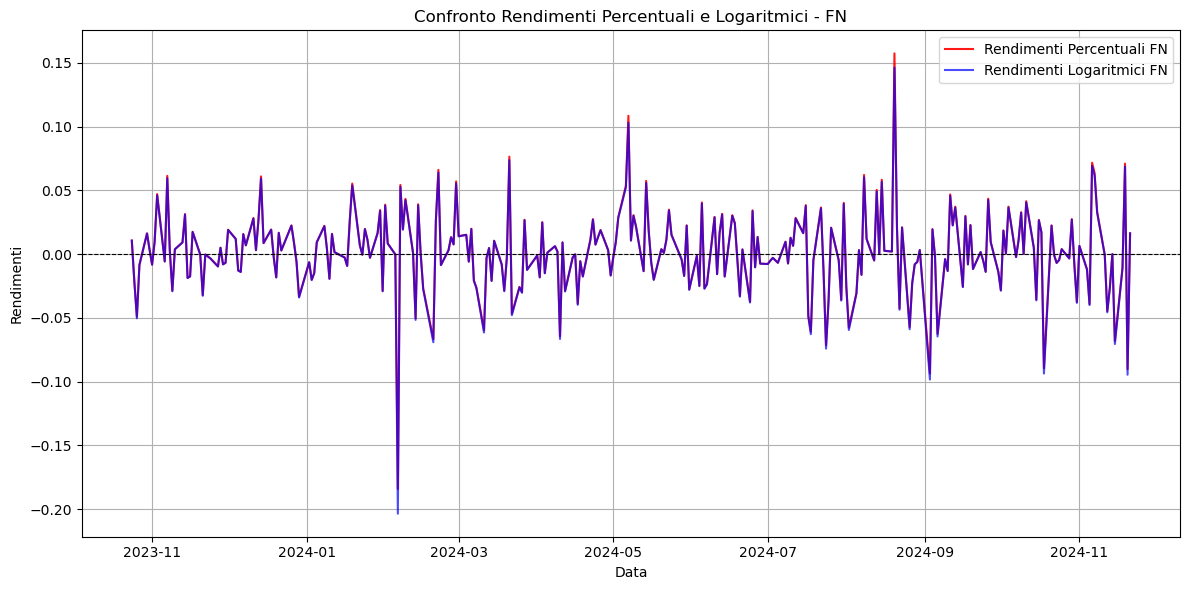

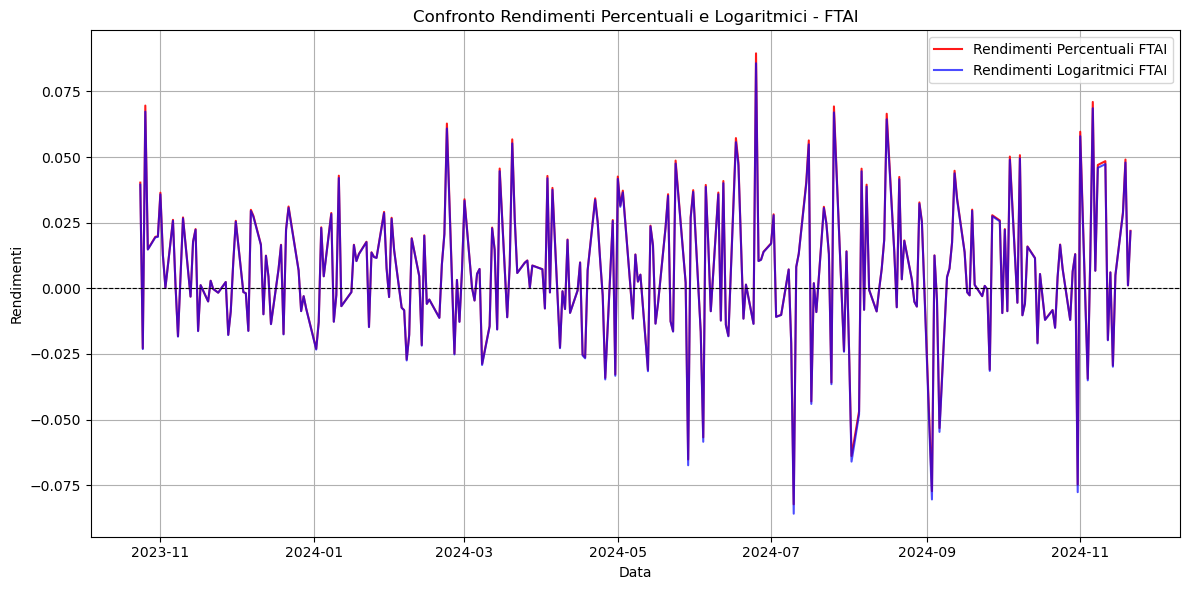

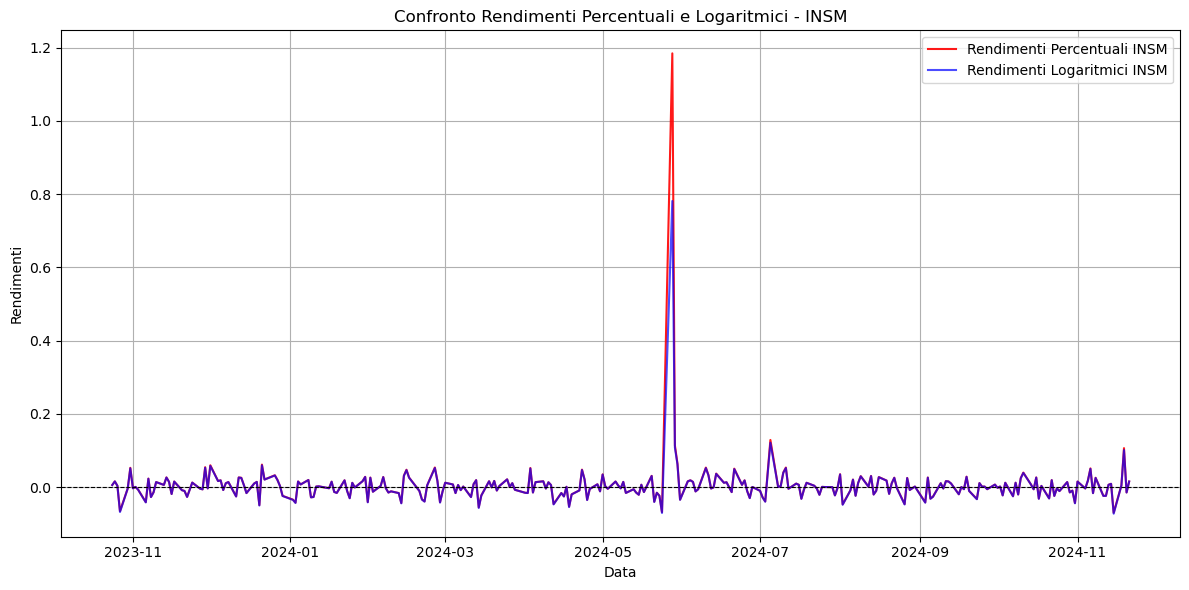

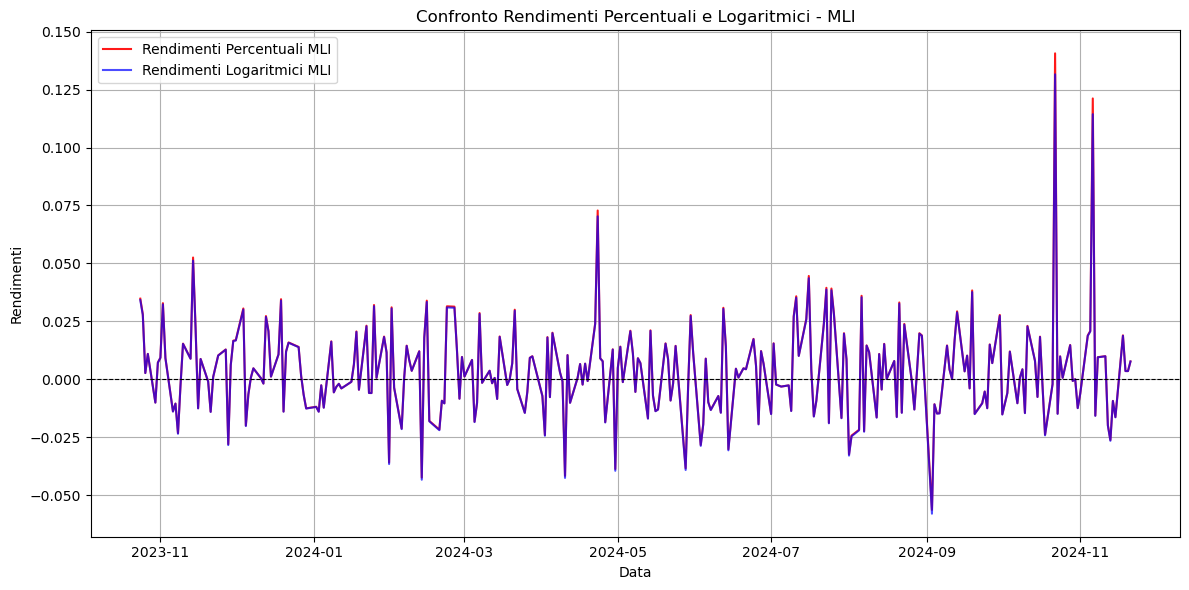

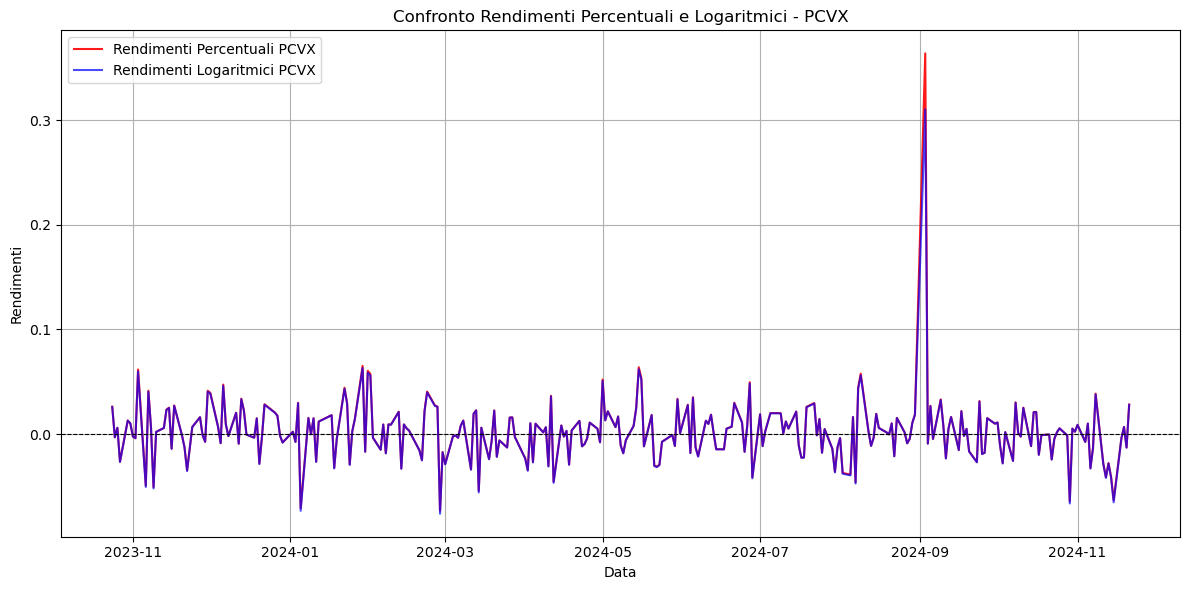

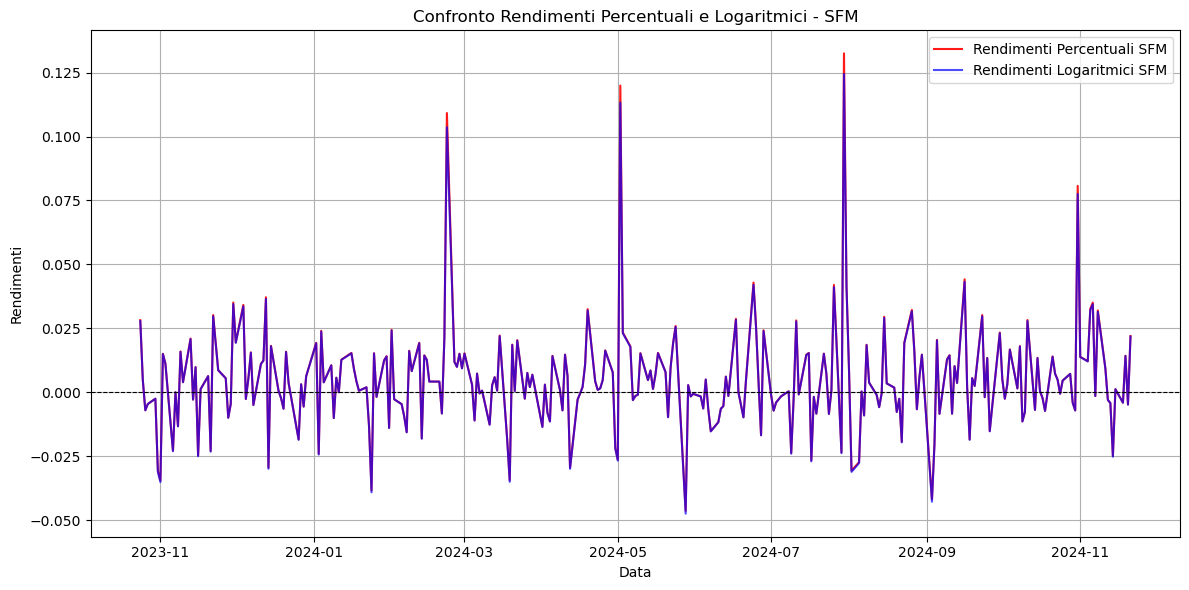

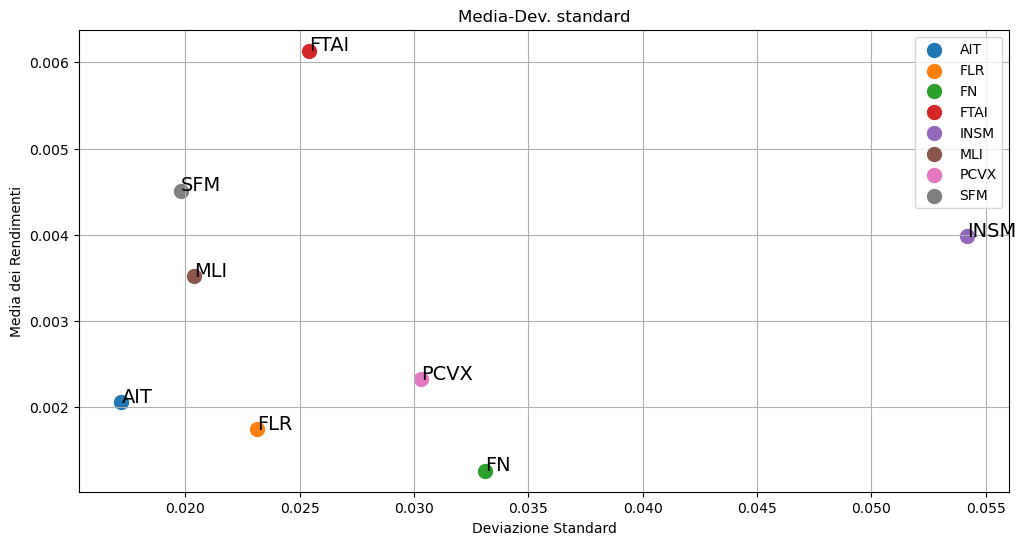

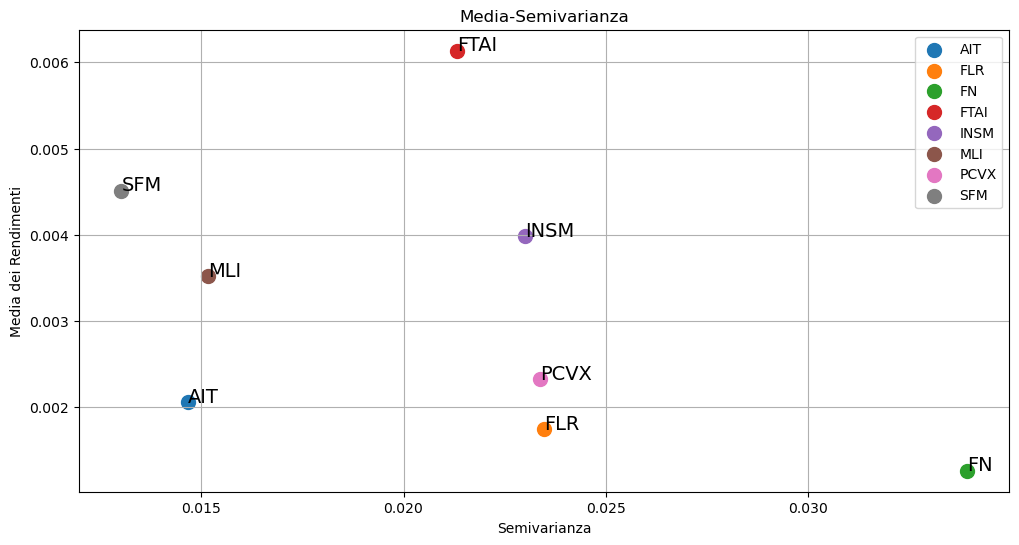


Tabella dei risultati per ciascun asset:
|      |      Media |   Deviazione Standard |   Semivarianza |
|:-----|-----------:|----------------------:|---------------:|
| AIT  | 0.00205525 |             0.0172027 |      0.0146722 |
| FLR  | 0.00174634 |             0.0231261 |      0.0234645 |
| FN   | 0.00126279 |             0.0330896 |      0.033914  |
| FTAI | 0.00613457 |             0.025412  |      0.0213174 |
| INSM | 0.00398032 |             0.054179  |      0.0230111 |
| MLI  | 0.00352079 |             0.0203636 |      0.015177  |
| PCVX | 0.0023214  |             0.0303132 |      0.0233785 |
| SFM  | 0.00451259 |             0.0197926 |      0.0130318 |


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "serie_storiche.xlsx"

data = pd.read_excel(file_path, index_col=0, parse_dates=True)

# Rendimenti percentuali logaritmici
log_returns = np.log(data / data.shift(1)).dropna()

# Rendimenti percentuali giornalieri
percent_returns = data.pct_change().dropna()

# Semivarianza
def calculate_semivariance(returns):
    negative_deviations = returns[returns < returns.mean()]
    semivariance = (negative_deviations ** 2).mean()
    return semivariance

# Statistiche per ciascun asset
mean_returns = log_returns.mean()
std_dev_returns = log_returns.std()
semivariances = log_returns.apply(calculate_semivariance)

results_table = pd.DataFrame({
    "Media": mean_returns,
    "Deviazione Standard": std_dev_returns,
    "Semivarianza": np.sqrt(semivariances)
})

log_returns.to_excel("log_returns.xlsx")

with pd.ExcelWriter("returns_comparison.xlsx") as writer:
    percent_returns.to_excel(writer, sheet_name="Rendimenti Percentuali")
    log_returns.to_excel(writer, sheet_name="Rendimenti Logaritmici")

# Grafici per ciascun asset
for asset in data.columns:
    asset_percent_returns = percent_returns[asset]
    asset_log_returns = log_returns[asset]

    plt.figure(figsize=(12, 6))

# Rendimenti percentuali
    plt.plot(asset_percent_returns.index, asset_percent_returns, label=f"Rendimenti Percentuali {asset}", color='red', alpha=0.9)

# Rendimenti logaritmici
    plt.plot(asset_log_returns.index, asset_log_returns, label=f"Rendimenti Logaritmici {asset}", color='blue', alpha=0.7)

# Grafico
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.xlabel('Data')
    plt.ylabel('Rendimenti')
    plt.title(f"Confronto Rendimenti Percentuali e Logaritmici - {asset}")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Grafico Media-Varianza
plt.figure(figsize=(12, 6))
for asset in std_dev_returns.index:
    plt.scatter(std_dev_returns[asset], mean_returns[asset], label=asset, s=100)
plt.xlabel("Deviazione Standard")
plt.ylabel("Media dei Rendimenti")
plt.title("Media-Dev. standard")
for asset in std_dev_returns.index:
    plt.annotate(asset, (std_dev_returns[asset], mean_returns[asset]), fontsize=14)
plt.grid()
plt.legend()
plt.show()

# Grafico Media-Semivarianza
plt.figure(figsize=(12, 6))
for asset in semivariances.index:
    plt.scatter(np.sqrt(semivariances[asset]), mean_returns[asset], label=asset, s=100)
plt.xlabel("Semivarianza")
plt.ylabel("Media dei Rendimenti")
plt.title("Media-Semivarianza")
for asset in semivariances.index:
    plt.annotate(asset, (np.sqrt(semivariances[asset]), mean_returns[asset]), fontsize=14)
plt.grid()
plt.legend()
plt.show()

# Tabella riassuntiva delle statistiche
print("\nTabella dei risultati per ciascun asset:")
print(results_table.to_markdown())


In [3]:
from scipy.optimize import minimize
import yfinance as yf
import numpy as np

# Scaricare i dati da Yahoo Finance
tickers = ["AIT", "FLR", "FN", "FTAI", "INSM", "MLI", "PCVX", "SFM"]
start_date = "2023-10-23"
end_date = "2024-11-22"
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calcolo dei rendimenti logaritmici
log_returns = np.log(data / data.shift(1)).dropna()

[*********************100%***********************]  8 of 8 completed


[*********************100%***********************]  8 of 8 completed


Pesi ottimali per rendimento atteso annualizzato 10%: [ 0.86921641  0.20852812  0.03463426 -0.26484184 -0.01302693 -0.17732203
  0.19220022  0.15061179]
Rischio annualizzato (deviazione standard): 0.2430881294141964


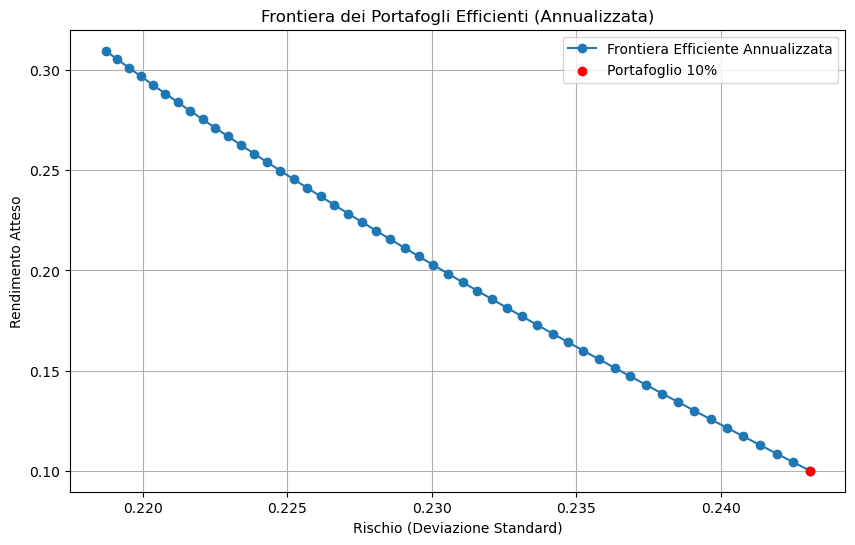

Pesi ottimali per rendimento atteso annualizzato del 10%:
AIT: 0.8692
FLR: 0.2085
FN: 0.0346
FTAI: -0.2648
INSM: -0.0130
MLI: -0.1773
PCVX: 0.1922
SFM: 0.1506
Rischio annualizzato (deviazione standard): 0.2431


In [149]:
# Scaricare i dati da Yahoo Finance
tickers = ["AIT", "FLR", "FN", "FTAI", "INSM", "MLI", "PCVX", "SFM"]
start_date = "2023-10-23"
end_date = "2024-11-22"
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calcolo dei rendimenti logaritmici
log_returns = np.log(data / data.shift(1)).dropna()

# Primi 200 rendimenti logaritmici per ciascun titolo
log_returns_subset = log_returns.iloc[:200]

# Calcolo dei rendimenti medi e matrice di covarianza (giornalieri)
mean_returns = log_returns_subset.mean().values
cov_matrix = log_returns_subset.cov().values

# Annualizzare i rendimenti e la covarianza
annualized_mean_returns = mean_returns * 252
annualized_cov_matrix = cov_matrix * 252

# Numero di titoli
num_assets = len(tickers)

# Funzione per calcolare il rischio del portafoglio (annualizzato)
def portfolio_risk_annualized(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Funzione per calcolare il rendimento del portafoglio (annualizzato)
def portfolio_return_annualized(weights, mean_returns):
    return np.dot(weights, mean_returns)

# Funzione obiettivo: minimizzare il rischio
def minimize_risk(weights, cov_matrix):
    return portfolio_risk_annualized(weights, cov_matrix)

# Vincoli generali
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]  # Somma dei pesi = 1
bounds = [(-np.inf, np.inf) for _ in range(num_assets)]  # Vendite allo scoperto permesse

# Frontiera efficiente
target_return = 0.10  
target_returns_annualized = np.linspace(annualized_mean_returns.min(), target_return, 50)
efficient_risks_annualized = []

for target in target_returns_annualized:
    constraints_with_target = constraints + [{'type': 'eq', 'fun': lambda w: portfolio_return_annualized(w, annualized_mean_returns) - target}]
    result = minimize(minimize_risk, x0=np.ones(num_assets)/num_assets, args=(annualized_cov_matrix,),
                      constraints=constraints_with_target, bounds=bounds, method='SLSQP')
    if result.success:
        efficient_risks_annualized.append(result.fun)
    else:
        efficient_risks_annualized.append(np.nan)

# Portafoglio con rendimento atteso annualizzato del 10%
constraints_with_target_10 = constraints + [{'type': 'eq', 'fun': lambda w: portfolio_return_annualized(w, annualized_mean_returns) - target_return}]
result_10_annualized = minimize(minimize_risk, x0=np.ones(num_assets)/num_assets, args=(annualized_cov_matrix,),
                                constraints=constraints_with_target_10, bounds=bounds, method='SLSQP')

if result_10_annualized.success:
    optimal_weights_annualized = result_10_annualized.x
    optimal_risk_annualized = portfolio_risk_annualized(optimal_weights_annualized, annualized_cov_matrix)
    print(f"Pesi ottimali per rendimento atteso annualizzato 10%: {optimal_weights_annualized}")
    print(f"Rischio annualizzato (deviazione standard): {optimal_risk_annualized}")
else:
    print("Non è possibile costruire un portafoglio con rendimento atteso annualizzato del 10%.")

# Tracciare la frontiera corretta
plt.figure(figsize=(10, 6))
plt.plot(efficient_risks_annualized, target_returns_annualized, label='Frontiera Efficiente Annualizzata', marker='o')
if result_10_annualized.success:
    plt.scatter(optimal_risk_annualized, target_return, color='red', label='Portafoglio 10%', zorder=5)
plt.title('Frontiera dei Portafogli Efficienti (Annualizzata)')
plt.xlabel('Rischio (Deviazione Standard)')
plt.ylabel('Rendimento Atteso')
plt.legend()
plt.grid()
plt.show()

if result_10_annualized.success:
    optimal_weights_annualized = result_10_annualized.x
    optimal_risk_annualized = portfolio_risk_annualized(optimal_weights_annualized, annualized_cov_matrix)
    
    weights_dict = {ticker: weight for ticker, weight in zip(tickers, optimal_weights_annualized)}
    
    print("Pesi ottimali per rendimento atteso annualizzato del 10%:")
    for asset, weight in weights_dict.items():
        print(f"{asset}: {weight:.4f}")
    
    print(f"Rischio annualizzato (deviazione standard): {optimal_risk_annualized:.4f}")
else:
    print("Non è possibile costruire un portafoglio con rendimento atteso annualizzato del 10%.")

[*********************100%***********************]  8 of 8 completed


Pesi ottimali per rendimento atteso annualizzato 10%: [-2.83019625e-02 -5.44213400e-04 -5.31042757e-03  2.65206947e-02
  5.73103876e-03  2.59159742e-02  1.65870696e-03  2.09978022e-02
  9.53332387e-01]
Rischio annualizzato (deviazione standard): 0.01546562081666931


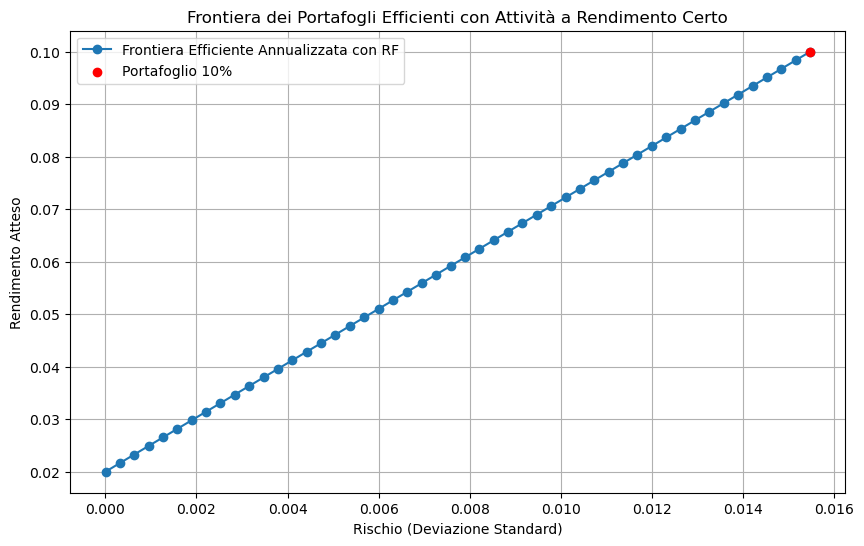

Pesi ottimali per rendimento atteso annualizzato del 10%:
AIT: -0.0283
FLR: -0.0005
FN: -0.0053
FTAI: 0.0265
INSM: 0.0057
MLI: 0.0259
PCVX: 0.0017
SFM: 0.0210
Risk-Free Asset: 0.9533
Rischio annualizzato (deviazione standard): 0.0155


In [151]:
tickers = ["AIT", "FLR", "FN", "FTAI", "INSM", "MLI", "PCVX", "SFM"]
start_date = "2023-10-23"
end_date = "2024-11-22"
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

log_returns = np.log(data / data.shift(1)).dropna()

log_returns_subset = log_returns.iloc[:200]

mean_returns = log_returns_subset.mean().values
cov_matrix = log_returns_subset.cov().values

annualized_mean_returns = mean_returns * 252
annualized_cov_matrix = cov_matrix * 252

num_assets = len(tickers)

# Rendimento certo positivo
r_f = 0.02

# Funzione per calcolare il rischio del portafoglio (annualizzato)
def portfolio_risk_annualized_with_rf(weights, cov_matrix):
    risky_weights = weights[:-1]  
    return np.sqrt(np.dot(risky_weights.T, np.dot(cov_matrix, risky_weights)))

# Funzione per calcolare il rendimento del portafoglio (annualizzato)
def portfolio_return_annualized_with_rf(weights, mean_returns, r_f):
    risky_weights = weights[:-1]  
    risk_free_weight = weights[-1]  
    return np.dot(risky_weights, mean_returns) + risk_free_weight * r_f

def minimize_risk_with_rf(weights, cov_matrix):
    return portfolio_risk_annualized_with_rf(weights, cov_matrix)

# Vincoli generali
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]  
bounds = [(-np.inf, np.inf) for _ in range(num_assets)] + [(0, 1)]  # Vendite allo scoperto

# Frontiera efficiente
target_return = 0.10  
target_returns_annualized = np.linspace(r_f, target_return, 50)
efficient_risks_annualized = []

for target in target_returns_annualized:
    constraints_with_target = constraints + [{'type': 'eq', 'fun': lambda w: portfolio_return_annualized_with_rf(w, annualized_mean_returns, r_f) - target}]
    result = minimize(minimize_risk_with_rf, x0=np.ones(num_assets + 1) / (num_assets + 1), args=(annualized_cov_matrix,),
                      constraints=constraints_with_target, bounds=bounds, method='SLSQP')
    if result.success:
        efficient_risks_annualized.append(result.fun)
    else:
        efficient_risks_annualized.append(np.nan)

# Portafoglio con rendimento atteso annualizzato del 10%
constraints_with_target_10 = constraints + [{'type': 'eq', 'fun': lambda w: portfolio_return_annualized_with_rf(w, annualized_mean_returns, r_f) - target_return}]
result_10_annualized = minimize(minimize_risk_with_rf, x0=np.ones(num_assets + 1) / (num_assets + 1), args=(annualized_cov_matrix,),
                                constraints=constraints_with_target_10, bounds=bounds, method='SLSQP')

if result_10_annualized.success:
    optimal_weights_annualized = result_10_annualized.x
    optimal_risk_annualized = portfolio_risk_annualized_with_rf(optimal_weights_annualized, annualized_cov_matrix)
    print(f"Pesi ottimali per rendimento atteso annualizzato 10%: {optimal_weights_annualized}")
    print(f"Rischio annualizzato (deviazione standard): {optimal_risk_annualized}")
else:
    print("Non è possibile costruire un portafoglio con rendimento atteso annualizzato del 10%.")

plt.figure(figsize=(10, 6))
plt.plot(efficient_risks_annualized, target_returns_annualized, label='Frontiera Efficiente Annualizzata con RF', marker='o')
if result_10_annualized.success:
    plt.scatter(optimal_risk_annualized, target_return, color='red', label='Portafoglio 10%', zorder=5)
plt.title('Frontiera dei Portafogli Efficienti con Attività a Rendimento Certo')
plt.xlabel('Rischio (Deviazione Standard)')
plt.ylabel('Rendimento Atteso')
plt.legend()
plt.grid()
plt.show()

if result_10_annualized.success:
    optimal_weights_annualized = result_10_annualized.x
    optimal_risk_annualized = portfolio_risk_annualized_with_rf(optimal_weights_annualized, annualized_cov_matrix)
    
    weights_dict = {ticker: weight for ticker, weight in zip(tickers, optimal_weights_annualized[:-1])}
    weights_dict["Risk-Free Asset"] = optimal_weights_annualized[-1]
    
    print("Pesi ottimali per rendimento atteso annualizzato del 10%:")
    for asset, weight in weights_dict.items():
        print(f"{asset}: {weight:.4f}")
    
    print(f"Rischio annualizzato (deviazione standard): {optimal_risk_annualized:.4f}")
else:
    print("Non è possibile costruire un portafoglio con rendimento atteso annualizzato del 10%.")


[*********************100%***********************]  8 of 8 completed


Pesi ottimali per rendimento atteso annualizzato 10%: [-3.88847425e-02 -1.78120844e-04 -7.49563252e-03  3.79731349e-02
  8.38323540e-03  3.70974133e-02  2.93881117e-03  3.12984557e-02
  9.28867445e-01]
Rischio annualizzato (deviazione standard): 0.022658893781881267


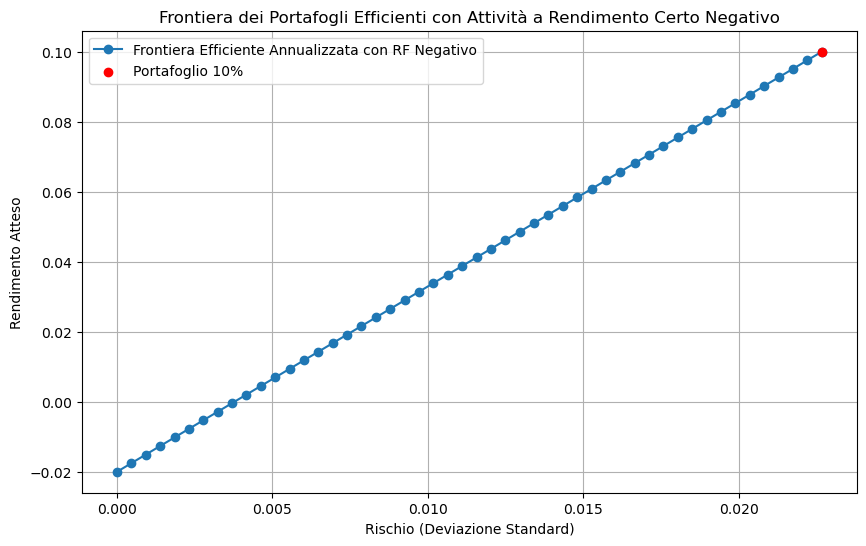

Pesi ottimali per rendimento atteso annualizzato del 10%:
AIT: -0.0389
FLR: -0.0002
FN: -0.0075
FTAI: 0.0380
INSM: 0.0084
MLI: 0.0371
PCVX: 0.0029
SFM: 0.0313
Risk-Free: 0.9289
Rischio annualizzato (deviazione standard): 0.0227


In [153]:
tickers = ["AIT", "FLR", "FN", "FTAI", "INSM", "MLI", "PCVX", "SFM"]
start_date = "2023-10-23"
end_date = "2024-11-22"
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

log_returns = np.log(data / data.shift(1)).dropna()

log_returns_subset = log_returns.iloc[:200]

mean_returns = log_returns_subset.mean().values
cov_matrix = log_returns_subset.cov().values

annualized_mean_returns = mean_returns * 252
annualized_cov_matrix = cov_matrix * 252

num_assets = len(tickers)

# Rendimento certo negativo
r_f = -0.02

def portfolio_risk_annualized_with_rf(weights, cov_matrix):
    risky_weights = weights[:-1]  # Escludere l'attività a rendimento certo
    return np.sqrt(np.dot(risky_weights.T, np.dot(cov_matrix, risky_weights)))

def portfolio_return_annualized_with_rf(weights, mean_returns, r_f):
    risky_weights = weights[:-1]  
    risk_free_weight = weights[-1]  
    return np.dot(risky_weights, mean_returns) + risk_free_weight * r_f

def minimize_risk_with_rf(weights, cov_matrix):
    return portfolio_risk_annualized_with_rf(weights, cov_matrix)

constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]  # Somma dei pesi = 1
bounds = [(-np.inf, np.inf) for _ in range(num_assets)] + [(0, 1)]  # Vendite allo scoperto per i titoli, ma non per l'attività priva di rischio

target_return = 0.10  # 10% rendimento annualizzato
target_returns_annualized = np.linspace(r_f, target_return, 50)
efficient_risks_annualized = []

for target in target_returns_annualized:
    constraints_with_target = constraints + [{'type': 'eq', 'fun': lambda w: portfolio_return_annualized_with_rf(w, annualized_mean_returns, r_f) - target}]
    result = minimize(minimize_risk_with_rf, x0=np.ones(num_assets + 1) / (num_assets + 1), args=(annualized_cov_matrix,),
                      constraints=constraints_with_target, bounds=bounds, method='SLSQP')
    if result.success:
        efficient_risks_annualized.append(result.fun)
    else:
        efficient_risks_annualized.append(np.nan)

constraints_with_target_10 = constraints + [{'type': 'eq', 'fun': lambda w: portfolio_return_annualized_with_rf(w, annualized_mean_returns, r_f) - target_return}]
result_10_annualized = minimize(minimize_risk_with_rf, x0=np.ones(num_assets + 1) / (num_assets + 1), args=(annualized_cov_matrix,),
                                constraints=constraints_with_target_10, bounds=bounds, method='SLSQP')

if result_10_annualized.success:
    optimal_weights_annualized = result_10_annualized.x
    optimal_risk_annualized = portfolio_risk_annualized_with_rf(optimal_weights_annualized, annualized_cov_matrix)
    print(f"Pesi ottimali per rendimento atteso annualizzato 10%: {optimal_weights_annualized}")
    print(f"Rischio annualizzato (deviazione standard): {optimal_risk_annualized}")
else:
    print("Non è possibile costruire un portafoglio con rendimento atteso annualizzato del 10%.")

plt.figure(figsize=(10, 6))
plt.plot(efficient_risks_annualized, target_returns_annualized, label='Frontiera Efficiente Annualizzata con RF Negativo', marker='o')
if result_10_annualized.success:
    plt.scatter(optimal_risk_annualized, target_return, color='red', label='Portafoglio 10%', zorder=5)
plt.title('Frontiera dei Portafogli Efficienti con Attività a Rendimento Certo Negativo')
plt.xlabel('Rischio (Deviazione Standard)')
plt.ylabel('Rendimento Atteso')
plt.legend()
plt.grid()
plt.show()

if result_10_annualized.success:
    optimal_weights_annualized = result_10_annualized.x
    optimal_risk_annualized = portfolio_risk_annualized_with_rf(optimal_weights_annualized, annualized_cov_matrix)
    
    weights_dict = {ticker: weight for ticker, weight in zip(tickers, optimal_weights_annualized[:-1])}
    weights_dict['Risk-Free'] = optimal_weights_annualized[-1]
    
    print("Pesi ottimali per rendimento atteso annualizzato del 10%:")
    for asset, weight in weights_dict.items():
        print(f"{asset}: {weight:.4f}")
    
    print(f"Rischio annualizzato (deviazione standard): {optimal_risk_annualized:.4f}")
else:
    print("Non è possibile costruire un portafoglio con rendimento atteso annualizzato del 10%.")


Pesi normalizzati.
Pesi normalizzati.


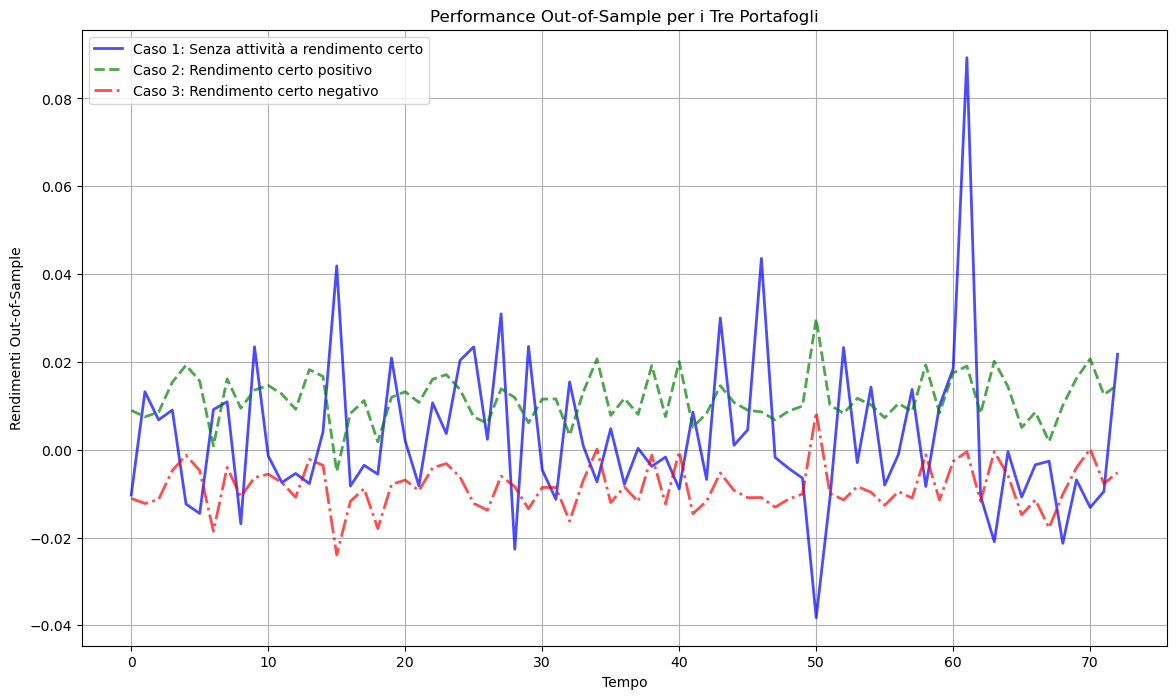


Performance Out-of-Sample:
Caso 1: Senza attività a rendimento certo
- Media: 0.002711, Varianza: 0.000323

Caso 2: Con attività a rendimento certo positivo
- Media: 0.011528, Varianza: 0.000030

Caso 3: Con attività a rendimento certo negativo
- Media: -0.008508, Varianza: 0.000027


In [155]:
# Caricamento dei dati
file_path = 'log_returns.xlsx'
data = pd.read_excel(file_path)
out_of_sample_returns = data.iloc[200:, 1:].to_numpy()  # Rendimenti out-of-sample

# Pesi ottimali forniti
weights_case1 = np.array([0.86921641, 0.20852812, 0.03463426, -0.26484184, -0.01302693, -0.17732203, 0.19220022, 0.15061179])

weights_case2_tangent = np.array([-2.83019625e-02, -5.44213400e-04, -5.31042757e-03, 2.65206947e-02,
                                  5.73103876e-03, 2.59159742e-02, 1.65870696e-03, 2.09978022e-02])
weights_case2_rf = 0.953332387

weights_case3_tangent = np.array([-3.88847425e-02, -1.78120844e-04, -7.49563252e-03, 3.79731349e-02,
                                  8.38323540e-03, 3.70974133e-02, 2.93881117e-03, 3.12984557e-02])
weights_case3_rf = 0.928867445

# Funzione per normalizzare i pesi
def normalize_weights(tangent_weights, risk_free_weight):
    sum_weights = tangent_weights.sum() + (1 - risk_free_weight)
    if not np.isclose(sum_weights, 1):
        correction_factor = 1 / sum_weights
        tangent_weights *= correction_factor
        risk_free_weight = 1 - tangent_weights.sum()
        print("Pesi normalizzati.")
    return tangent_weights, risk_free_weight

# Normalizzazione pesi per Caso 2
weights_case2_tangent, weights_case2_rf = normalize_weights(weights_case2_tangent, weights_case2_rf)

# Normalizzazione pesi per Caso 3
weights_case3_tangent, weights_case3_rf = normalize_weights(weights_case3_tangent, weights_case3_rf)

# Calcolo delle performance out-of-sample
# Caso 1
out_sample_case1 = np.dot(out_of_sample_returns, weights_case1)
mean_out_sample_case1 = out_sample_case1.mean()
var_out_sample_case1 = out_sample_case1.var()

# Caso 2: Con attività a rendimento certo positivo
risk_free_return_case2 = 0.02
out_sample_case2_tangent = np.dot(out_of_sample_returns, weights_case2_tangent)
out_sample_case2 = weights_case2_rf * risk_free_return_case2 + (1 - weights_case2_rf) * out_sample_case2_tangent
mean_out_sample_case2 = out_sample_case2.mean()
var_out_sample_case2 = out_sample_case2.var()

# Caso 3: Con attività a rendimento certo negativo
risk_free_return_case3 = -0.02
out_sample_case3_tangent = np.dot(out_of_sample_returns, weights_case3_tangent)
out_sample_case3 = weights_case3_rf * risk_free_return_case3 + (1 - weights_case3_rf) * out_sample_case3_tangent
mean_out_sample_case3 = out_sample_case3.mean()
var_out_sample_case3 = out_sample_case3.var()

# Visualizzazione delle performance out-of-sample
plt.figure(figsize=(14, 8))

# Caso 1: Senza attività a rendimento certo
plt.plot(out_sample_case1, label="Caso 1: Senza attività a rendimento certo", color="blue", linestyle="-", linewidth=2, alpha=0.7)

# Caso 2: Rendimento certo positivo
plt.plot(out_sample_case2, label="Caso 2: Rendimento certo positivo", color="green", linestyle="--", linewidth=2, alpha=0.7)

# Caso 3: Rendimento certo negativo
plt.plot(out_sample_case3, label="Caso 3: Rendimento certo negativo", color="red", linestyle="-.", linewidth=2, alpha=0.7)

plt.xlabel("Tempo")
plt.ylabel("Rendimenti Out-of-Sample")
plt.title("Performance Out-of-Sample per i Tre Portafogli")
plt.legend()
plt.grid()
plt.show()

# Output delle performance
print("\nPerformance Out-of-Sample:")
print("Caso 1: Senza attività a rendimento certo")
print(f"- Media: {mean_out_sample_case1:.6f}, Varianza: {var_out_sample_case1:.6f}")

print("\nCaso 2: Con attività a rendimento certo positivo")
print(f"- Media: {mean_out_sample_case2:.6f}, Varianza: {var_out_sample_case2:.6f}")

print("\nCaso 3: Con attività a rendimento certo negativo")
print(f"- Media: {mean_out_sample_case3:.6f}, Varianza: {var_out_sample_case3:.6f}")


Pesi normalizzati.
Pesi normalizzati.


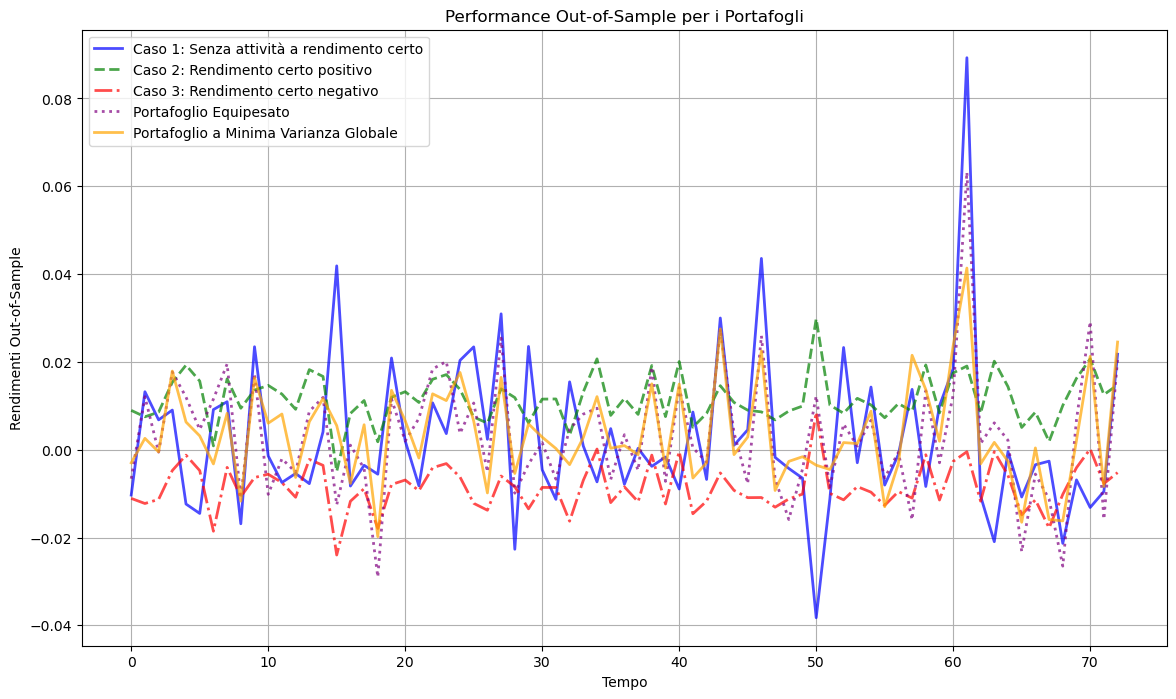


Performance Out-of-Sample:
Caso 1: Senza attività a rendimento certo
- Media: 0.002711, Varianza: 0.000323

Caso 2: Con attività a rendimento certo positivo
- Media: 0.011528, Varianza: 0.000030

Caso 3: Con attività a rendimento certo negativo
- Media: -0.008508, Varianza: 0.000027

Portafoglio Equipesato
- Media: 0.003220, Varianza: 0.000202

Portafoglio a Minima Varianza Globale
- Media: 0.003640, Varianza: 0.000127


In [157]:
# Caricamento dei dati
file_path = 'log_returns.xlsx'
data = pd.read_excel(file_path)
out_of_sample_returns = data.iloc[200:, 1:].to_numpy()  # Rendimenti out-of-sample
cov_matrix = np.cov(out_of_sample_returns, rowvar=False)
num_assets = out_of_sample_returns.shape[1]

# Pesi ottimali forniti
weights_case1 = np.array([0.86921641, 0.20852812, 0.03463426, -0.26484184, -0.01302693, -0.17732203, 0.19220022, 0.15061179])

weights_case2_tangent = np.array([-2.83019625e-02, -5.44213400e-04, -5.31042757e-03, 2.65206947e-02,
                                  5.73103876e-03, 2.59159742e-02, 1.65870696e-03, 2.09978022e-02])
weights_case2_rf = 0.953332387

weights_case3_tangent = np.array([-3.88847425e-02, -1.78120844e-04, -7.49563252e-03, 3.79731349e-02,
                                  8.38323540e-03, 3.70974133e-02, 2.93881117e-03, 3.12984557e-02])
weights_case3_rf = 0.928867445

# Funzione per normalizzare i pesi
def normalize_weights(tangent_weights, risk_free_weight):
    sum_weights = tangent_weights.sum() + (1 - risk_free_weight)
    if not np.isclose(sum_weights, 1):
        correction_factor = 1 / sum_weights
        tangent_weights *= correction_factor
        risk_free_weight = 1 - tangent_weights.sum()
        print("Pesi normalizzati.")
    return tangent_weights, risk_free_weight

# Normalizzazione pesi per Caso 2
weights_case2_tangent, weights_case2_rf = normalize_weights(weights_case2_tangent, weights_case2_rf)

# Normalizzazione pesi per Caso 3
weights_case3_tangent, weights_case3_rf = normalize_weights(weights_case3_tangent, weights_case3_rf)

# Calcolo dei pesi per il portafoglio equipesato
weights_equal = np.ones(num_assets) / num_assets

# Calcolo dei pesi per il portafoglio a minima varianza globale
def calculate_global_minimum_variance_weights(cov_matrix):
    num_assets = cov_matrix.shape[0]
    ones = np.ones(num_assets)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    weights = np.dot(inv_cov_matrix, ones) / np.dot(ones, np.dot(inv_cov_matrix, ones))
    return weights

weights_min_var = calculate_global_minimum_variance_weights(cov_matrix)

# Calcolo delle performance out-of-sample
# Caso 1
out_sample_case1 = np.dot(out_of_sample_returns, weights_case1)
mean_out_sample_case1 = out_sample_case1.mean()
var_out_sample_case1 = out_sample_case1.var()

# Caso 2: Con attività a rendimento certo positivo
risk_free_return_case2 = 0.02
out_sample_case2_tangent = np.dot(out_of_sample_returns, weights_case2_tangent)
out_sample_case2 = weights_case2_rf * risk_free_return_case2 + (1 - weights_case2_rf) * out_sample_case2_tangent
mean_out_sample_case2 = out_sample_case2.mean()
var_out_sample_case2 = out_sample_case2.var()

# Caso 3: Con attività a rendimento certo negativo
risk_free_return_case3 = -0.02
out_sample_case3_tangent = np.dot(out_of_sample_returns, weights_case3_tangent)
out_sample_case3 = weights_case3_rf * risk_free_return_case3 + (1 - weights_case3_rf) * out_sample_case3_tangent
mean_out_sample_case3 = out_sample_case3.mean()
var_out_sample_case3 = out_sample_case3.var()

# Portafoglio equipesato
out_sample_equal = np.dot(out_of_sample_returns, weights_equal)
mean_out_sample_equal = out_sample_equal.mean()
var_out_sample_equal = out_sample_equal.var()

# Portafoglio a minima varianza globale
out_sample_min_var = np.dot(out_of_sample_returns, weights_min_var)
mean_out_sample_min_var = out_sample_min_var.mean()
var_out_sample_min_var = out_sample_min_var.var()

# Visualizzazione delle performance out-of-sample
plt.figure(figsize=(14, 8))

# Caso 1: Senza attività a rendimento certo
plt.plot(out_sample_case1, label="Caso 1: Senza attività a rendimento certo", color="blue", linestyle="-", linewidth=2, alpha=0.7)

# Caso 2: Rendimento certo positivo
plt.plot(out_sample_case2, label="Caso 2: Rendimento certo positivo", color="green", linestyle="--", linewidth=2, alpha=0.7)

# Caso 3: Rendimento certo negativo
plt.plot(out_sample_case3, label="Caso 3: Rendimento certo negativo", color="red", linestyle="-.", linewidth=2, alpha=0.7)

# Portafoglio equipesato
plt.plot(out_sample_equal, label="Portafoglio Equipesato", color="purple", linestyle=":", linewidth=2, alpha=0.7)

# Portafoglio a minima varianza globale
plt.plot(out_sample_min_var, label="Portafoglio a Minima Varianza Globale", color="orange", linestyle="-", linewidth=2, alpha=0.7)

plt.xlabel("Tempo")
plt.ylabel("Rendimenti Out-of-Sample")
plt.title("Performance Out-of-Sample per i Portafogli")
plt.legend()
plt.grid()
plt.show()

# Output delle performance
print("\nPerformance Out-of-Sample:")
print("Caso 1: Senza attività a rendimento certo")
print(f"- Media: {mean_out_sample_case1:.6f}, Varianza: {var_out_sample_case1:.6f}")

print("\nCaso 2: Con attività a rendimento certo positivo")
print(f"- Media: {mean_out_sample_case2:.6f}, Varianza: {var_out_sample_case2:.6f}")

print("\nCaso 3: Con attività a rendimento certo negativo")
print(f"- Media: {mean_out_sample_case3:.6f}, Varianza: {var_out_sample_case3:.6f}")

print("\nPortafoglio Equipesato")
print(f"- Media: {mean_out_sample_equal:.6f}, Varianza: {var_out_sample_equal:.6f}")

print("\nPortafoglio a Minima Varianza Globale")
print(f"- Media: {mean_out_sample_min_var:.6f}, Varianza: {var_out_sample_min_var:.6f}")

In [159]:
# Scaricare i dati da Yahoo Finance
tickers = ["AIT", "FLR", "FN", "FTAI", "INSM", "MLI", "PCVX", "SFM"]
start_date = "2023-10-23"
end_date = "2024-11-22"
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calcolo dei rendimenti logaritmici
log_returns = np.log(data / data.shift(1)).dropna()

# Considerare i primi 200 rendimenti logaritmici per ciascun titolo
log_returns_subset = log_returns.iloc[:200]

# Calcolo dei rendimenti medi e matrice di covarianza (giornalieri)
mean_returns = log_returns_subset.mean().values
cov_matrix = log_returns_subset.cov().values

# Annualizzare i rendimenti e la covarianza
annualized_mean_returns = mean_returns * 252  
annualized_cov_matrix = cov_matrix * 252

# Funzione per calcolare il rapporto di Sharpe 
def sharpe_ratio(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns) 
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  
    return -portfolio_return / portfolio_volatility  
    
def optimize_portfolio(mean_returns, cov_matrix, target_return):

    num_assets = len(mean_returns)
    initial_weights = np.ones(num_assets) / num_assets
    
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return},  
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1} 
    )
    
    bounds = [(-1, 1)] * num_assets  
    
    result = minimize(sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

target_return = 0.10  

optimal_weights = optimize_portfolio(annualized_mean_returns, annualized_cov_matrix, target_return)

# Visualizzazione dei risultati
print("Pesi ottimali del portafoglio:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print(f"La somma dei pesi è: {np.sum(optimal_weights):.4f}")

portfolio_return = np.dot(optimal_weights, annualized_mean_returns)  
print(f"Rendimento annuo del portafoglio: {portfolio_return:.2%}")

# Calcolare la volatilità annua
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(annualized_cov_matrix, optimal_weights)))
print(f"Volatilità annua del portafoglio: {portfolio_volatility:.2%}")

[*********************100%***********************]  8 of 8 completed

Pesi ottimali del portafoglio:
AIT: 0.8691
FLR: 0.2088
FN: 0.0346
FTAI: -0.2648
INSM: -0.0131
MLI: -0.1771
PCVX: 0.1920
SFM: 0.1504
La somma dei pesi è: 1.0000
Rendimento annuo del portafoglio: 10.00%
Volatilità annua del portafoglio: 24.31%


In [165]:
tickers = ["AIT", "FLR", "FN", "FTAI", "INSM", "MLI", "PCVX", "SFM"]
start_date = "2023-10-23"
end_date = "2024-11-22"
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

log_returns = np.log(data / data.shift(1)).dropna()

log_returns_subset = log_returns.iloc[:200]

mean_returns = log_returns_subset.mean().values
cov_matrix = log_returns_subset.cov().values

annualized_mean_returns = mean_returns * 252  
annualized_cov_matrix = cov_matrix * 252

certainty_asset_return = 0.02  
certainty_asset_cov = 0  
certainty_asset_mean_return = certainty_asset_return
certainty_asset_cov_matrix = np.array([[certainty_asset_cov]])

annualized_mean_returns = np.append(annualized_mean_returns, certainty_asset_mean_return)
annualized_cov_matrix = np.vstack([np.hstack([annualized_cov_matrix, np.zeros((annualized_cov_matrix.shape[0], 1))]), np.zeros((1, annualized_cov_matrix.shape[1] + 1))])

def sharpe_ratio(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)  
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  
    return -portfolio_return / portfolio_volatility 

def optimize_portfolio(mean_returns, cov_matrix, target_return):

    num_assets = len(mean_returns)
    initial_weights = np.ones(num_assets) / num_assets
    
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return}, 
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  
    )
    
    bounds = [(-1, 1)] * num_assets  
    
    result = minimize(sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

target_return = 0.10  

optimal_weights = optimize_portfolio(annualized_mean_returns, annualized_cov_matrix, target_return)

print("Pesi ottimali del portafoglio:")
for ticker, weight in zip(tickers + ["Certainty Asset"], optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print(f"La somma dei pesi è: {np.sum(optimal_weights):.4f}")

portfolio_return = np.dot(optimal_weights, annualized_mean_returns)  # Rendimento annuo
print(f"Rendimento annuo del portafoglio: {portfolio_return:.2%}")

portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(annualized_cov_matrix, optimal_weights)))
print(f"Volatilità annua del portafoglio: {portfolio_volatility:.2%}")

[*********************100%***********************]  8 of 8 completed

Pesi ottimali del portafoglio:
AIT: -0.0283
FLR: -0.0005
FN: -0.0053
FTAI: 0.0265
INSM: 0.0057
MLI: 0.0259
PCVX: 0.0017
SFM: 0.0210
Certainty Asset: 0.9533
La somma dei pesi è: 1.0000
Rendimento annuo del portafoglio: 10.00%
Volatilità annua del portafoglio: 1.55%


In [163]:
# Scaricare i dati da Yahoo Finance
tickers = ["AIT", "FLR", "FN", "FTAI", "INSM", "MLI", "PCVX", "SFM"]
start_date = "2023-10-23"
end_date = "2024-11-22"
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

log_returns = np.log(data / data.shift(1)).dropna()

log_returns_subset = log_returns.iloc[:200]

mean_returns = log_returns_subset.mean().values
cov_matrix = log_returns_subset.cov().values

annualized_mean_returns = mean_returns * 252  
annualized_cov_matrix = cov_matrix * 252

# Aggiungere un asset con rendimento certo negativo (-2%)
certainty_asset_return = -0.02 
certainty_asset_cov = 0  
certainty_asset_mean_return = certainty_asset_return
certainty_asset_cov_matrix = np.array([[certainty_asset_cov]])

annualized_mean_returns = np.append(annualized_mean_returns, certainty_asset_mean_return)
annualized_cov_matrix = np.vstack([np.hstack([annualized_cov_matrix, np.zeros((annualized_cov_matrix.shape[0], 1))]), np.zeros((1, annualized_cov_matrix.shape[1] + 1))])

def sharpe_ratio(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns) 
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  
    return -portfolio_return / portfolio_volatility  

def optimize_portfolio(mean_returns, cov_matrix, target_return):

    num_assets = len(mean_returns)
    initial_weights = np.ones(num_assets) / num_assets
    
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return},  
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  
    )
    
    bounds = [(-1, 1)] * num_assets  
    
    result = minimize(sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

target_return = 0.10 

optimal_weights = optimize_portfolio(annualized_mean_returns, annualized_cov_matrix, target_return)

print("Pesi ottimali del portafoglio:")
for ticker, weight in zip(tickers + ["Certainty Asset"], optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print(f"La somma dei pesi è: {np.sum(optimal_weights):.4f}")

portfolio_return = np.dot(optimal_weights, annualized_mean_returns)  # Rendimento annuo
print(f"Rendimento annuo del portafoglio: {portfolio_return:.2%}")

portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(annualized_cov_matrix, optimal_weights)))
print(f"Volatilità annua del portafoglio: {portfolio_volatility:.2%}")

[*********************100%***********************]  8 of 8 completed

Pesi ottimali del portafoglio:
AIT: -0.0390
FLR: -0.0001
FN: -0.0076
FTAI: 0.0380
INSM: 0.0083
MLI: 0.0373
PCVX: 0.0030
SFM: 0.0311
Certainty Asset: 0.9289
La somma dei pesi è: 1.0000
Rendimento annuo del portafoglio: 10.00%
Volatilità annua del portafoglio: 2.27%


Pesi normalizzati.
Pesi normalizzati.


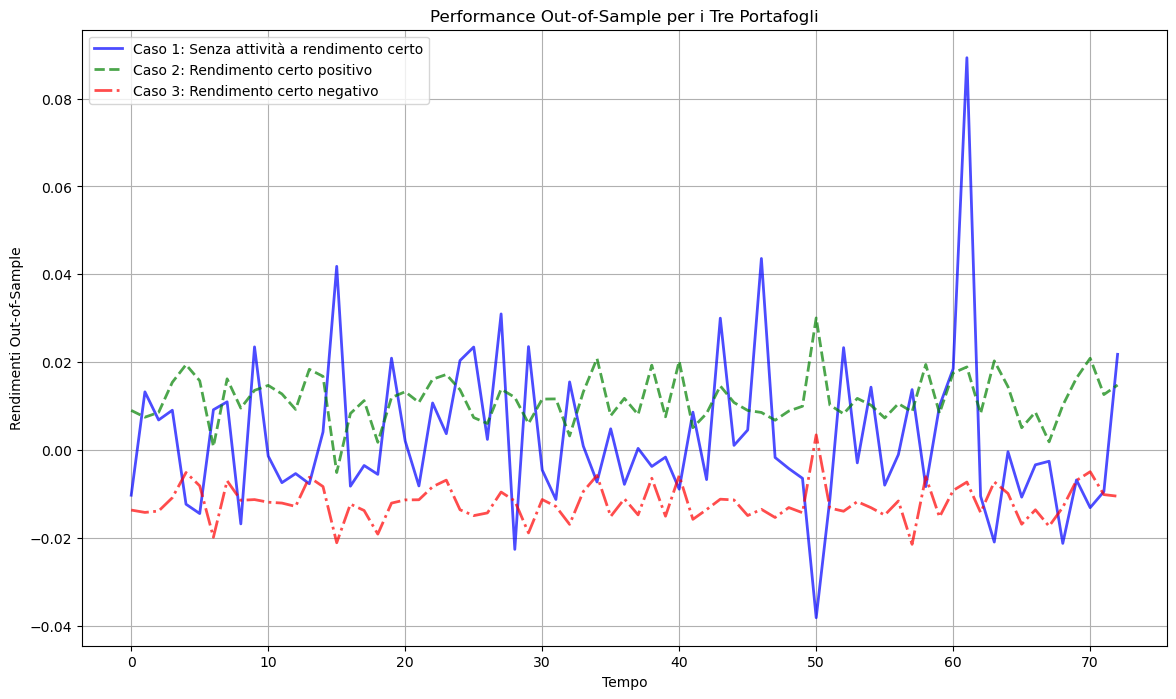


Performance Out-of-Sample:
Caso 1: Senza attività a rendimento certo
- Media: 0.002711, Varianza: 0.000323

Caso 2: Con attività a rendimento certo positivo
- Media: 0.011534, Varianza: 0.000031

Caso 3: Con attività a rendimento certo negativo
- Media: -0.011995, Varianza: 0.000017


In [161]:
# Caricamento dei dati
file_path = 'log_returns.xlsx'
data = pd.read_excel(file_path)
out_of_sample_returns = data.iloc[200:, 1:].to_numpy()  # Rendimenti out-of-sample

# Pesi ottimali forniti (aggiornati)
weights_case1 = np.array([0.8691, 0.2088, 0.0346, -0.2648, -0.0131, -0.1771, 0.1920, 0.1504])

weights_case2_tangent = np.array([-0.0253, -0.0005, -0.0047, 0.0235, 0.0051, 0.0228, 0.0014, 0.0184])
weights_case2_rf = 0.9593  # Peso dell'attività priva di rischio

weights_case3_tangent = np.array([-0.0413, 0.0000, -0.0082, 0.0407, 0.0090, 0.0400, 0.0033, 0])
weights_case3_rf = 0.9228  # Peso dell'attività priva di rischio

# Funzione per normalizzare i pesi
def normalize_weights(tangent_weights, risk_free_weight):
    sum_weights = tangent_weights.sum() + (1 - risk_free_weight)
    if not np.isclose(sum_weights, 1):
        correction_factor = 1 / sum_weights
        tangent_weights *= correction_factor
        risk_free_weight = 1 - tangent_weights.sum()
        print("Pesi normalizzati.")
    return tangent_weights, risk_free_weight

# Normalizzazione pesi per Caso 2 e Caso 3
weights_case2_tangent, weights_case2_rf = normalize_weights(weights_case2_tangent, weights_case2_rf)
weights_case3_tangent, weights_case3_rf = normalize_weights(weights_case3_tangent, weights_case3_rf)

# Funzione per calcolare il rendimento annualizzato
def annualized_return(daily_mean_return):
    return (1 + daily_mean_return) ** 252 - 1

# Calcolo delle performance out-of-sample
# Caso 1: Solo gli asset
out_sample_case1 = np.dot(out_of_sample_returns, weights_case1)
mean_out_sample_case1 = out_sample_case1.mean()
var_out_sample_case1 = out_sample_case1.var()

# Caso 2: Con attività a rendimento certo positivo
risk_free_return_case2 = 0.02  # Rendimento dell'attività priva di rischio
out_sample_case2_tangent = np.dot(out_of_sample_returns, weights_case2_tangent)
out_sample_case2 = weights_case2_rf * risk_free_return_case2 + (1 - weights_case2_rf) * out_sample_case2_tangent
mean_out_sample_case2 = out_sample_case2.mean()
var_out_sample_case2 = out_sample_case2.var()

# Caso 3: Con attività a rendimento certo negativo
risk_free_return_case3 = -0.02  # Rendimento dell'attività priva di rischio
out_sample_case3_tangent = np.dot(out_of_sample_returns, weights_case3_tangent)
out_sample_case3 = weights_case3_rf * risk_free_return_case3 + (1 - weights_case3_rf) * out_sample_case3_tangent
mean_out_sample_case3 = out_sample_case3.mean()
var_out_sample_case3 = out_sample_case3.var()

# Visualizzazione delle performance out-of-sample
plt.figure(figsize=(14, 8))

# Caso 1
plt.plot(out_sample_case1, label="Caso 1: Senza attività a rendimento certo", color="blue", linestyle="-", linewidth=2, alpha=0.7)

# Caso 2: Rendimento certo positivo
plt.plot(out_sample_case2, label="Caso 2: Rendimento certo positivo", color="green", linestyle="--", linewidth=2, alpha=0.7)

# Caso 3: Rendimento certo negativo
plt.plot(out_sample_case3, label="Caso 3: Rendimento certo negativo", color="red", linestyle="-.", linewidth=2, alpha=0.7)

plt.xlabel("Tempo")
plt.ylabel("Rendimenti Out-of-Sample")
plt.title("Performance Out-of-Sample per i Tre Portafogli")
plt.legend()
plt.grid()
plt.show()

# Output delle performance
print("\nPerformance Out-of-Sample:")
print("Caso 1: Senza attività a rendimento certo")
print(f"- Media: {mean_out_sample_case1:.6f}, Varianza: {var_out_sample_case1:.6f}")

print("\nCaso 2: Con attività a rendimento certo positivo")
print(f"- Media: {mean_out_sample_case2:.6f}, Varianza: {var_out_sample_case2:.6f}")

print("\nCaso 3: Con attività a rendimento certo negativo")
print(f"- Media: {mean_out_sample_case3:.6f}, Varianza: {var_out_sample_case3:.6f}")
